In [32]:
import random
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt

import igraph
import networkx as nx

from utils import extract_rolx_roles

import warnings
warnings.filterwarnings('ignore')

In [2]:
N_ROLES = 4

edgelist = '../graphs/erasmus.weighted.edgelist'
G_nx = nx.read_weighted_edgelist(edgelist, create_using=nx.DiGraph)
G = igraph.Graph.from_networkx(G_nx)

In [3]:
V, H, M, K, Q = extract_rolx_roles(G, n_roles=4)

Creating Vertex/Node Features matrix
V is a 3292 by 196 matrix.
Node-role matrix is of dimensions 3292 by 4
Node-feature matrix is of dimensions 3292 by 8
Role-feature matrix is of dimensions 4 by 8
Role-neighbor matrix is of dimensions 4 by 4


## Concat node_feature and node_role Matrices

In [21]:
node_role_percentage = np.asarray(H)
# df_node_role = pd.DataFrame(index=np.arange(H.shape[0]),columns=['role'])
df_node_role = pd.DataFrame(index=list(G_nx.nodes),columns=['role'])
for i, node in enumerate(node_role_percentage):
    r = np.argmax(node)
    df_node_role.iloc[i] = r

features = [ 'betweenness', 'closeness', 'degree', 'diversity', 'eccentricity', 'pagerank', 'personalized_pagerank', 'strength' ]
df_node_feature = pd.DataFrame(data=M, index=list(G_nx.nodes), columns=features)

df_node_feature_role = pd.concat([df_node_feature, df_node_role], axis=1)
display(df_node_feature_role)

# save the file
# df_node_feature_role.to_csv('../data/node_feature_role.csv')

,betweenness,closeness,degree,diversity,eccentricity,pagerank,personalized_pagerank,strength,role
A__BADEN01,0.000244,0.017403,0.003210,0.017429,0.019494,0.005429,0.005429,0.003210,1
B__ANTWERP59,0.018824,0.020344,0.024279,0.017429,0.016245,0.026732,0.026732,0.024279,0
D__BREMEN01,0.024836,0.021462,0.047355,0.017429,0.016245,0.040601,0.040601,0.047355,0
D__POTSDAM01,0.014553,0.021015,0.040432,0.017429,0.019494,0.036894,0.036894,0.040432,0
E__LAS-PAL01,0.072978,0.021365,0.062605,0.017429,0.019494,0.061265,0.061265,0.062605,0
...,...,...,...,...,...,...,...,...,...
TR_YOZGAT01,0.000000,0.016026,0.001104,0.017429,0.019494,0.001865,0.001865,0.001104,3
UK_DUNDEE04,0.000000,0.013642,0.000100,0.017429,0.019494,0.001865,0.001865,0.000100,3
Unknown_BG,0.000000,0.014607,0.000100,0.017429,0.019494,0.001865,0.001865,0.000100,1
Unknown_EE,0.000000,0.014529,0.000100,0.017429,0.022743,0.001865,0.001865,0.000100,1


## Display the Network

In [23]:
# show only portion of the nodes in the network
# df_node_role.reset_index(inplace=True)
selected_indices = []
percentage = 0.1

for n in range(N_ROLES):
    indices = df_node_role.index[(df_node_role['role'] == n)].tolist()
    # print(indices)
    selected_indices.extend(random.sample(indices, round(len(indices) * percentage)))

df_draw = df_node_role.iloc[selected_indices].copy()
# display(df_draw)

,index,role
506,F__MULHOUS01,0
1029,F__MARSEIL94,0
13,UK_MANCHES04,0
995,D__STUTTGA02,0
702,F__LYON12,0
...,...,...
2983,UK_PERTH02,3
2654,TR_ORDU01,3
3055,UK_LONDOND02,3
3248,RO_BUCURES17,3


In [24]:
color_map = []
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, r in df_draw.iterrows():
    color_map.append(colors[r['role']])
    
mapping = {}
for i, name in enumerate(list(G_nx.nodes)):
    mapping[name] = i
# print(mapping)
G_relabel = nx.relabel_nodes(G_nx, mapping)

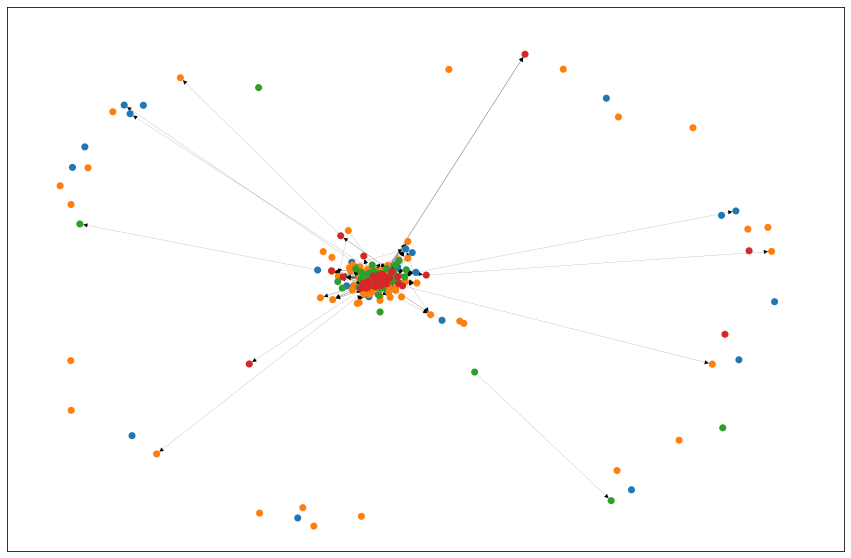

In [31]:
pos = nx.spring_layout(G_relabel)
sg = G_relabel.subgraph(selected_indices)

# draw graph
options = {
    'pos': pos,
    'node_color': color_map,
    'node_size': 50,
    'linewidths': 0,
    'width': 0.1,
    'with_labels': False,}

pylab.figure(figsize=(15,10))
nx.draw_networkx(sg, **options)
pylab.show()

## Sensemaking

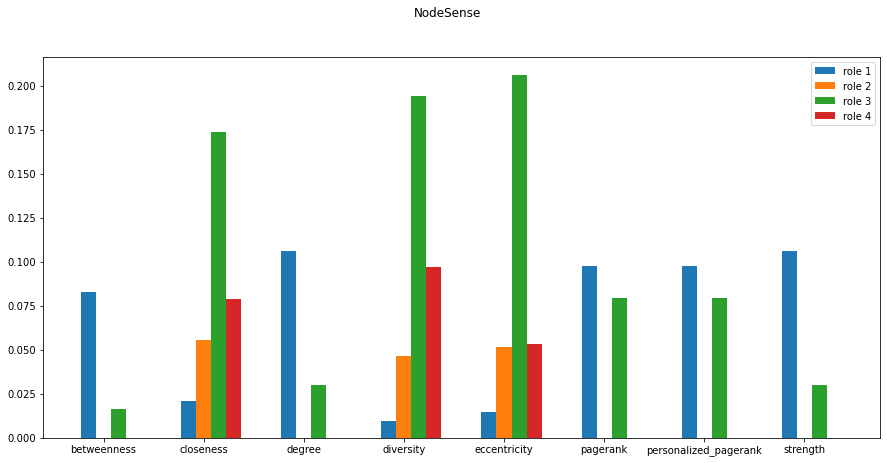

In [33]:
n_features = len(features)

index = np.arange(n_features)
bar_width = .15

fig = plt.figure(figsize=(15,7))
fig.suptitle('NodeSense')

rect1 = plt.bar(index, np.asarray(K[0,:]).flatten(), bar_width, label='role 1')
rect2 = plt.bar(index+bar_width, np.asarray(K[1,:]).flatten(), bar_width, label='role 2')
rect3 = plt.bar(index+bar_width*2, np.asarray(K[2,:]).flatten(), bar_width, label='role 3')
rect4 = plt.bar(index+bar_width*3, np.asarray(K[3,:]).flatten(), bar_width, label='role 4')

plt.legend()
plt.xticks(index+bar_width, features)
plt.show()

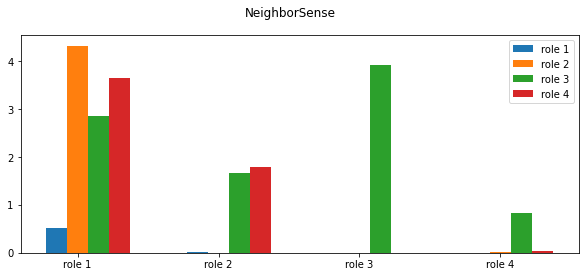

In [34]:
n_roles = 4
index = np.arange(n_roles)
bar_width = .15

fig = plt.figure(figsize=(10,4))
fig.suptitle('NeighborSense')

rect1 = plt.bar(index, np.asarray(Q[0,:]).flatten(), bar_width, label='role 1')
rect2 = plt.bar(index+bar_width, np.asarray(Q[1,:]).flatten(), bar_width, label='role 2')
rect3 = plt.bar(index+bar_width*2, np.asarray(Q[2,:]).flatten(), bar_width, label='role 3')
rect4 = plt.bar(index+bar_width*3, np.asarray(Q[3,:]).flatten(), bar_width, label='role 4')

plt.legend()
plt.xticks(index+bar_width, ['role 1', 'role 2', 'role 3', 'role 4'])
plt.show()

## Reference
- [graphwave](https://github.com/snap-stanford/graphwave/blob/master/graphwave/benchmark_algorithms/roleX.py)